# Automatically Group Paths to Signs

As a prehistory: The photo of the middle part of the [Demotic astronomical papyrus Pap. Berlin P 8279+23547](https://id.smb.museum/object/823520/griechisch-demotischer-papyrus-mit-getreideabrechnungen-und-sterntafeln-pap--berlin-p-8279---p-23547). This photo comprises the parts E-F on the verso of the papyrus and has been downloaded from [https://id.smb.museum/object/823520](https://recherche.smb.museum/images/69/6935950_4000x4000.jpg) and stored as [P_08279_V_002.jpg](./photos/P_08279_V_002.jpg). The corners of the photo have been marked with 21 x 21 px squares, to be able to anchor the outline of the papyrus, the signs and the boundaries relative to each other. This manipulated photo has been saved as [P_08279_V_002.jpg](./photos/P_08279_V_002.png). With the help of Inkscape the manupulated photo has been converted into a svg vector graphic. The result of this 1st step is: [P_08279_V_002_step01.svg](./svgs/P_08279_V_002_step01.svg) This svg has been cleaned up. The result of this 2nd step is: [P_08279_V_002_step02.svg](./svgs/P_08279_V_002_step02.svg) Finally, the columns have been marked on it manually. The result of this 3rd step is: [P_08279_V_002_step03.svg](./svgs/P_08279_V_002_step03.svg) In the next step the infomation which sign belongs into which column has been written into the svg. The [previous notebook](./1_AsignSigns2Columns.ipynb) asigned the path of the signs the column there are in, resulting in [P_08279_V_002_step04.svg](./svgs/P_08279_V_002_step04.svg). 

## Preample

### Use the full width of the screen available

In [127]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Import necessary packages

configparser is used to easily read in the [configuration file](./config.properties). As svgs are based on xml, bs4 is used to manipulate the svg. pandas is used to drop duplicates in the names of connected paths. matplotlib is a library to display graphs, it is used here for draw the color coded shapes of the signs, display and save these graphs for manual inspections of the results. svgpath2mpl is used to handle the svgs while shapely turns the paths from the svgs into polygons so that they can be handled in a more efficient way in Python. itertools is used to generate all combinations of possibly connected svg paths, which are then merged into one path. numpy turns the polygons into numerical data for plotting with matplotlib.

In [128]:
import configparser
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
from svgpath2mpl import parse_path
from shapely.geometry import Polygon
import itertools
import numpy as np

### Read the config file

When reading in the config the comments are ignored as well as any capitalization. The config is split into a general part and a one that is specific for each papyrus photo that is worked on. In the following the general config `configGen` may be accessed by `configGen[field]`.

In [129]:
config = configparser.RawConfigParser()
config.read('./config.properties')

configGen = dict(config.items('general'))
configPap = dict(config.items(configGen['workpap']))

## Main Part

### Open the svg and process it with bs4

Read the file to work on and the number of the step from the configs above. Don't forget to increase the step number by one as done below, as the svg has been passed through the notebook [1_AsignSigns2Columns.ipynb](./1_AsignSigns2Columns.ipynb) before.

In [130]:
numStep = int(configPap['numstep'])
filename = configPap['filename'] + '_step' + str(numStep + 1).zfill(2) + '.svg'

Here the svg is opened and (as svg is based on xml) processed with bs4. All used column labels are extracted and stored in the variable `col`.

In [131]:
with open(configGen['svgdir'] + filename, 'r') as f:
    file = f.read() 
soup = bs(file, 'xml')

In [132]:
col = []
for element in soup.find_all('path', style=lambda x: 'stroke:#ff0000' in x):
    col.append(element.get('inkscape:label'))

This function graps all paths from the svg transform them into a dictionary of the form `{'id': 'path'}`. These are then stored yet again in a dictionary with the column the path is in as a key. So the final dictionary has the following form: `signs = {'colI': {'id1': 'path1', 'id2': 'path2', ...}, 'colII': ...}`. This makes the paths easier to handle in Python.

In [133]:
signs = {}
for c in col:
    signs[c] = {}
    for element in soup.find_all(attrs={"column": c}):
        signs[c][element.get('id')] = element.get('d')

### Concat connecting paths

The following function determines if two path intersect or contain each other (either path A contains path B or vice versa). In order to connect neighboring paths that only nearly intersect but do form one sign, a buffer is applied. This buffer basically expands the signs by the number of pixels stated in the [configuration file](./config.properties) in the property `buffer`. As all signs are expanded in this way a value of e.g. 5 px for the buffer actually means that paths that are 10 px apart will still be merged into one path. It is important to choose the buffer in a way that never to signs that belong into different rows are merged together. On the other hand the buffer should not be to small so that it does merge the maximum amount of path that form part of one sign together. The ideal value should be the maximum value for which no signs from different rows are merged together, the buffer value needs to be updated until this is the case. The graphics at the lower part of this notebook are there to check that not two signs from different rows are merged.

In [134]:
def findConnectedPaths(signs, buffer):
    pathcontainedinother = {}
    bufferedsigns = {}
    connected = {}
    for c in col:
        pathcontainedinother[c] = {}
        bufferedsigns[c] = {}
        connected[c] = []
        for s in signs[c]:
            bufferedsigns[c][s] = Polygon(parse_path(signs[c][s]).to_polygons()[0]).buffer(buffer, join_style='bevel')
        dic = pathcontainedinother[c]
        for p, b in itertools.combinations(list(signs[c].keys()), 2):
            if bufferedsigns[c][b].contains(bufferedsigns[c][p]) or bufferedsigns[c][p].contains(bufferedsigns[c][b]) or bufferedsigns[c][b].intersection(bufferedsigns[c][p]):
                if p not in list(pathcontainedinother[c].keys()):
                    pathcontainedinother[c][p] = [p]
                if b not in pathcontainedinother[c][p]:
                    pathcontainedinother[c][p].append(b)
        connected[c].append(list(pathcontainedinother[c].values()))
        connected[c] = connected[c][0]
    return connected

This function gathers the names of all connected paths, even if they are only indirectly connected (meaning path A and C are not directly connected but both are connected with path B and therefore indirectly connected).

In [135]:
def concatPaths(connected):
    connect = connected.copy()
    for c in col:
        for j, k in itertools.combinations(connect[c], 2):
            if len(set(j).intersection(set(k))) != 0:
                try:
                    connect[c].remove(j)
                    connect[c].remove(k)
                except:
                    pass
                j = set(j).union(set(k))
                connect[c].append(list(j))
    return connect

When the (in)directly joined paths are concated, subsets of other entries may remain in the list. These are deleted with this function.

In [136]:
def removeSubsets(connected):
    connect = connected.copy()
    for c in col:
        for j, k in itertools.combinations(connect[c], 2):
            try:
                if set(j) != set(k):
                    if set(j).issubset(set(k)):
                        connect[c].remove(j)
                    if set(k).issubset(set(j)):
                        connect[c].remove(k)
            except:
                pass
    return connect

This function turns the list of names of connected paths per column into a set, so that duplicates can be easily sorted out.

In [137]:
def makeSets(connected):
    connect = {}
    for c in col:
        connect[c] = []
        for s in connected[c]:
            connect[c].append(set(s))
    return connect

This function drops the duplicates. While the detour via a pandas DataFrame is not ideal from a programmic standpoint, it helps to speed up the process and is a foolproof working approach.

In [138]:
def removeDuplicates(connected):
    connect = {}
    for c in col:
        df = pd.DataFrame(connected[c]).drop_duplicates()
        connect[c] = [[y for y in x if pd.notna(y)] for x in df.values.tolist()]
    return connect

To merge the actual paths together later on, is easier if the a dict of the following form exists: `{path1: [connectedPath1, connectedPath2...]}` This function builds such a dictionary. The first entry of the list of names of connected paths is used as the key of the dictionary, the remaining names of connected paths from the list remain in the form of a list and form the value of the dictionary.

In [139]:
def makeDict(connected):
    connect = {}
    for c in col:
        connect[c] = {}
        for k in connected[c]:
            connect[c][k[0]] = k[1:]
    return connect

The value for the buffer is read from the [configuration file](./config.properties), for an explanation what this buffer means refer to its explanation above or in the config file. Then, as the first step the function findConnectedPaths (described above) to the signs. Afterwards, the names of connected paths are concated (fuction explained above) two times and the resulting list of names of connected paths is turned into a set. It is not ideal that the `concatPaths` function has to be executed multiple times to gather all (in)direct connected paths, but this is a working roundabout for now. Afterwards, still not all connected paths are still concated, so two more executions are necessary to achieve that. However, as each execution of the `concatPaths` function adds more entries to the list of names of connected paths,  executing the `concatPaths` function four times in a row would result into a huge increase in computation time the list of names of connected paths is cleaned from unnecessary subsets and duplicates (functions explained above) after two applications of the `concatPaths` function each. At the end, the list of names of connected paths is transform into a dictionary (function explained above) for easier processing afterwards.

In [140]:
buffer = float(configPap['buffer'])

connectedPaths = findConnectedPaths(signs, buffer)
connectedPaths = makeSets(concatPaths(concatPaths(connectedPaths)))
connectedPaths = makeDict(removeDuplicates(removeSubsets(concatPaths(concatPaths(removeDuplicates(removeSubsets(connectedPaths)))))))

/home/sabrina/anaconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


So far, all that we have is a dictionary of names of connected paths but the paths themselves are not merged yet. This is done in the following cell. The individual unmerged paths are dropped after merging.

In [141]:
keys2delete = {}
for c in col:
    keys2delete[c] = list(itertools.chain.from_iterable(connectedPaths[c].values()))
    for s in signs[c].keys():
        if s in connectedPaths[c].keys():
            for p in connectedPaths[c][s]:
                signs[c][s] = signs[c][s] + ' ' + signs[c][p]
    for k in keys2delete[c]:
        del signs[c][k]

The following cell displayes all signs including the merged paths. All parts of a merged path have the same color, that is different from neighboring paths, so that is easily distingishable if two shapes are part of the same path or not. Unfortunately the order of the columns is inverted, meaning the rightmost column on the papyrus is displayed on the far left here. So far I have not find a way to fix this. As the displayed graphic in this notebook is small, the graphic is also exported as a jpg file into the folder [controlgraphs](./controlgraphs/). This graphic has to be inspected carefully to check that no two signs from different rows are merged together. If this is the case lower the value of the buffer in the [configuration file](./config.properties) by one and execute the notebook until the following cell and check again. If on the other hand there are no two signs from different columns connected increase the value of the buffer until there are at least two signs from different rows connected, lower the value of the buffer by one and you have the desired maximal value of the buffer so that not two signs from different rows are connected. It is highly desireable to automate this process of trial and error, though. It might be possible to enhance this merge process by using a kind of OCR (in case of tabular data, where we are dealing mainly with individual signs) or HTR (in case of textual data, where a lot of ligatures occur and therefore the whole line of text hast to be taken into consideration). As merging path into signs is not the primary goal of this workflow, this will not be done here.

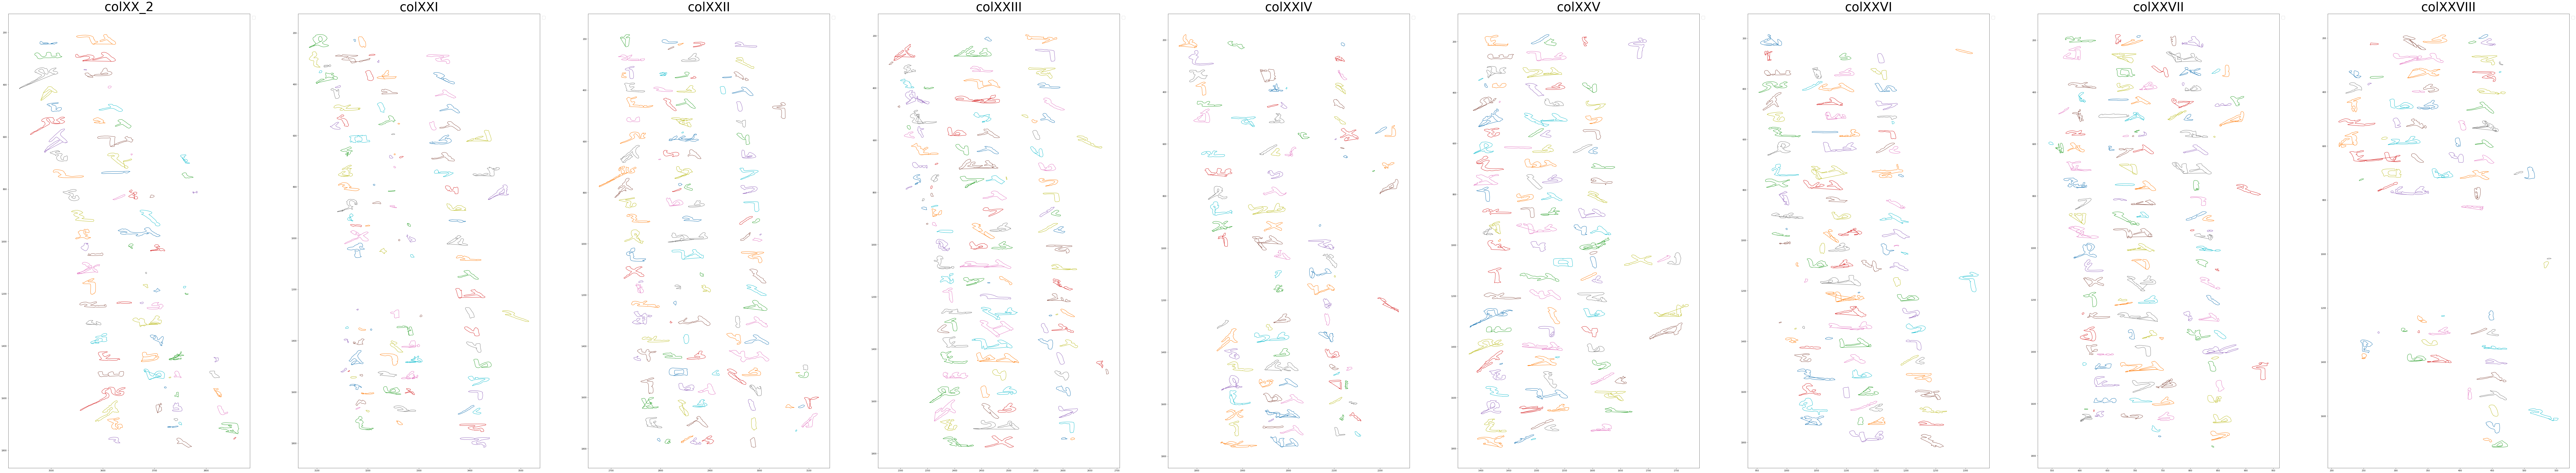

In [142]:
plt.figure(figsize = (55*4, 10*4))
legend = []
for i in list(range(len(col))):
    plt.subplot(1, len(col), i + 1)
    plt.gca().invert_yaxis()
    for s in list(signs[col[i]].keys()):
        polyex = np.concatenate(parse_path(signs[col[i]][s]).to_polygons(), axis = 0).T
        plt.plot(*polyex)
    plt.title(col[i], fontsize = 60)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 20, handles=legend)
plt.savefig(configGen['controlgraphsdir'] + configPap['filename'] + '_afterMerge_step' + str(numStep + 1).zfill(2) + '.jpg')

The following cell add new connected paths to the svg and drops the old unconnected paths from the svg.

In [143]:
for c in col:
    for s in list(signs[c].keys()):
        soup.find(attrs={'id' : s})['d'] = signs[c][s]
    for d in keys2delete[c]:
        soup.find(attrs={'id' : d}).extract()

## End

Finally, the modified svg is exported under the original directory and filename but the step number is increased by one to avoid overwriting the original svg.

In [144]:
with open('./svgs/' + filename.replace('_step' + str(numStep + 1).zfill(2), '_step' + str(numStep + 2).zfill(2)), 'w') as f:
    f.write(soup.prettify())